In [17]:
import numpy as np

# this reads the data (corpus), builds a vocabulary and
# dictionary to index the characters of the corpus
class DataReader:
    def __init__(self, data, seq_length):
        self.data = data  # Use the passed 'data' parameter to set 'self.data'
        chars = list(set(self.data))
        self.char_to_ix = {ch: i for i, ch in enumerate(chars)}
        self.ix_to_char = {i: ch for i, ch in enumerate(chars)}
        self.vocab_size = len(chars)
        self.seq_length = seq_length
        self.data_size = len(self.data)

    def next_batch(self):
        # for our current window
        input_start = self.pointer
        input_end = self.pointer + self.seq_length
        # take all characters in that window
        inputs = [self.char_to_ix[ch] for ch in self.data[input_start:input_end]]
        # ... and try to predict the NEXT character
        targets = [self.char_to_ix[ch] for ch in self.data[input_start+1:input_end+1]]
        # go to next window
        self.pointer += self.seq_length
        if self.pointer + self.seq_length + 1 >= self.data_size:
            # reset pointer
            self.pointer = 0
        return inputs, targets

    def just_started(self):
        return self.pointer == 0

    def close(self):
        self.fp.close()


In [18]:
# bare-bones implementation of RNN
class RNN:
    # inputs: size of hidden layer, size of vocabulary,
    # window size, learning rate for gradient descent
    def __init__(self, hidden_size, vocab_size, seq_length, learning_rate):
        # hyper parameters
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        # initialization of model weight matrices
        self.U = np.random.uniform(-np.sqrt(1./vocab_size), np.sqrt(1./vocab_size), (hidden_size, vocab_size))
        self.V = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (vocab_size, hidden_size))
        self.W = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size))
        self.b = np.zeros((hidden_size, 1)) # bias for hidden layer
        self.c = np.zeros((vocab_size, 1)) # bias for output

        # the original implementation from Andrej uses
        # ADAGRAD, which tracks the weight changes and
        # makes use of these additional matrices
        self.mU = np.zeros_like(self.U)
        self.mW = np.zeros_like(self.W)
        self.mV = np.zeros_like(self.V)
        self.mb = np.zeros_like(self.b)
        self.mc = np.zeros_like(self.c)

    # standard softmax implementation for probability output
    def softmax(self, x):
        p = np.exp(x- np.max(x))
        return p / np.sum(p)

    # forward pass through the RNN
    # given the previous state
    def forward(self, inputs, hprev):
            xs, hs, os, ycap = {}, {}, {}, {}
            hs[-1] = np.copy(hprev)
            for t in range(len(inputs)):
                xs[t] = np.zeros((self.vocab_size,1))
                # one hot encoding, 1-of-k
                xs[t][inputs[t]] = 1
                # hidden state of the RNN
                hs[t] = np.tanh(np.dot(self.U,xs[t]) + np.dot(self.W,hs[t-1]) + self.b)
                # non-normalized log probalities for the next characters
                os[t] = np.dot(self.V,hs[t]) + self.c
                # probabilities for the next character
                ycap[t] = self.softmax(os[t])
            return xs, hs, ycap

    # backprop through the network given all states and targets
    def backward(self, xs, hs, ps, targets):
            # backward pass: compute gradients going backwards
            dU, dW, dV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
            db, dc = np.zeros_like(self.b), np.zeros_like(self.c)
            dhnext = np.zeros_like(hs[0])
            # go backwards
            for t in reversed(range(self.seq_length)):
                dy = np.copy(ps[t])
                # through softmax
                # backprop into y [BCE loss]
                dy[targets[t]] -= 1
                # calculate dV, dc
                dV += np.dot(dy, hs[t].T)
                dc += dc
                # dh includes gradient from two sides,
                # the next cell and the current output
                # backprop into h
                dh = np.dot(self.V.T, dy) + dhnext
                # backprop through tanh non-linearity
                dhrec = (1 - hs[t] * hs[t]) * dh
                # bias change
                db += dhrec
                # calculate dU and dW
                dU += np.dot(dhrec, xs[t].T)
                dW += np.dot(dhrec, hs[t-1].T)
                # pass the gradient from next cell
                # to the next iteration.
                dhnext = np.dot(self.W.T, dhrec)
            # clip to avoid *exploding* gradients
            # note that this does NOT avoid vanishing
            # gradients
            for dparam in [dU, dW, dV, db, dc]:
                np.clip(dparam, -5, 5, out=dparam)
            return dU, dW, dV, db, dc

    # defines loss for a window of characters
    def loss(self, ps, targets):
            # cross-entropy loss
            return sum(-np.log(ps[t][targets[t],0]) for t in range(self.seq_length))

    # parameter update using ADAGRAD
    def update_model(self, dU, dW, dV, db, dc):
        # take all parameters
        for param, dparam, mem in zip([self.U, self.W, self.V, self.b, self.c],
                                  [dU, dW, dV, db, dc],
                                  [self.mU, self.mW, self.mV, self.mb, self.mc]):
            # apply memory
            mem += dparam*dparam
            # update parameters dampened by memory
            param += -self.learning_rate*dparam/np.sqrt(mem+1e-8) # adagrad update

    # this function samples from the model
    # inputs are the hidden memory state and a seed character,
    # and the number of samples to be made
    def sample(self, h, seed_ix, n):
            x = np.zeros((self.vocab_size, 1))
            # one-hot encoding
            x[seed_ix] = 1
            ixes = []
            for t in range(n):
                # go through the model and get the probabilities
                h = np.tanh(np.dot(self.U, x) + np.dot(self.W, h) + self.b)
                y = np.dot(self.V, h) + self.c
                p = np.exp(y)/np.sum(np.exp(y))
                # choose among the characters
                ix = np.random.choice(range(self.vocab_size), p = p.ravel())
                # set to chosen character and append
                x = np.zeros((self.vocab_size,1))
                x[ix] = 1
                ixes.append(ix)
            return ixes

    # train loop
    def train(self, data_reader):
            iter_num = 0
            threshold = 0.01
            # set loss to random predictor
            smooth_loss = -np.log(1.0/data_reader.vocab_size)*self.seq_length
            while (smooth_loss > threshold):
                if data_reader.just_started():
                    hprev = np.zeros((self.hidden_size,1))
                inputs, targets = data_reader.next_batch()
                # forward, backward, loss, update
                xs, hs, ps = self.forward(inputs, hprev)
                dU, dW, dV, db, dc = self.backward(xs, hs, ps, targets)
                loss = self.loss(ps, targets)
                self.update_model(dU, dW, dV, db, dc)
                smooth_loss = smooth_loss*0.999 + loss*0.001
                hprev = hs[self.seq_length-1]
                if not iter_num%500:
                    # sample 200 characters from the model
                    # given the current first batch character as seed
                    sample_ix = self.sample(hprev, inputs[0], 200)
                    print( ''.join(data_reader.ix_to_char[ix] for ix in sample_ix))
                    print( "\n\niter :%d, loss:%f"%(iter_num, smooth_loss))
                iter_num += 1

    # predict a set of characters
    def predict(self, data_reader, start, n):
        # initialize input vector
        x = np.zeros((self.vocab_size,1))
        chars = [ch for ch in start]
        ixes = []
        for i in range(len(chars)):
            ix = data_reader.char_to_ix[chars[i]]
            x[ix] = 1
            ixes.append(ix)

        h = np.zeros((self.hidden_size,1))
        # predict next n chars
        for t in range(n):
            h = np.tanh(np.dot(self.U, x) + np.dot(self.W, h) + self.b)
            y = np.dot(self.V, h) + self.c
            p = np.exp(y)/np.sum(np.exp(y))
            ix = np.random.choice(range(self.vocab_size), p = p.ravel())
            x = np.zeros((self.vocab_size,1))
            x[ix] = 1
            ixes.append(ix)
        txt = ''.join(data_reader.ix_to_char[i] for i in ixes)
        return txt
    
    

In [22]:

sequence_lengths = [10, 20, 30, 50]  # Different sequence lengths to compare
performance_metrics = {}  # To store performance metrics for each sequence length
number_of_iterations = 5000  # Adjust as needed
hidden_size = 100  # Size of the hidden layer of neurons
learning_rate = 1e-1  # Learning rate for the RNN


patience = 500  # Number of iterations to wait for improvement
best_loss = float('inf')
iterations_since_improvement = 0


# Load the text data
with open('/workspace/KU_NN/2023020923_2023020928_A5/ABC_Carols_combined.txt', 'r') as file:
    carols_text = file.read()



def lossFun(inputs, targets, hprev, rnn):
    """
    inputs, targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0

    # Forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((rnn.vocab_size, 1))  # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(rnn.U, xs[t]) + np.dot(rnn.W, hs[t - 1]) + rnn.b)  # hidden state
        ys[t] = np.dot(rnn.V, hs[t]) + rnn.c  # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))  # probabilities for next chars
        loss += -np.log(ps[t][targets[t], 0])  # softmax (cross-entropy loss)

    # Backward pass: compute gradients going backwards
    dU, dW, dV = np.zeros_like(rnn.U), np.zeros_like(rnn.W), np.zeros_like(rnn.V)
    db, dc = np.zeros_like(rnn.b), np.zeros_like(rnn.c)
    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1  # backprop into y
        dV += np.dot(dy, hs[t].T)
        dc += dy
        dh = np.dot(rnn.V.T, dy) + dhnext  # backprop into h
        dhrec = (1 - hs[t] * hs[t]) * dh  # backprop through tanh nonlinearity
        db += dhrec
        dU += np.dot(dhrec, xs[t].T)
        dW += np.dot(dhrec, hs[t-1].T)
        dhnext = np.dot(rnn.W.T, dhrec)

    for dparam in [dU, dW, dV, db, dc]:
        np.clip(dparam, -5, 5, out=dparam)  # mitigate exploding gradients

    return loss, dU, dW, dV, db, dc, hs[len(inputs)-1]




for seq_length in sequence_lengths:
    # Reset the best_loss and iterations_since_improvement for each sequence length
    best_loss = float('inf')
    iterations_since_improvement = 0
    
    # Initialize the data reader for each sequence length
    data_reader = DataReader(carols_text, seq_length)
    rnn = RNN(hidden_size, data_reader.vocab_size, seq_length, learning_rate)
    mU, mW, mV = np.zeros_like(rnn.U), np.zeros_like(rnn.W), np.zeros_like(rnn.V)
    mb, mc = np.zeros_like(rnn.b), np.zeros_like(rnn.c)

    n, p = 0, 0
    hprev = np.zeros((rnn.hidden_size, 1))  # reset the hidden state
    losses = []  # To store losses for this sequence length
    
    while n < number_of_iterations:
        # Prepare inputs
        if p + seq_length + 1 >= len(data_reader.data) or n == 0:
            hprev = np.zeros((rnn.hidden_size, 1))
            p = 0

        inputs = [data_reader.char_to_ix[ch] for ch in data_reader.data[p:p + seq_length]]
        targets = [data_reader.char_to_ix[ch] for ch in data_reader.data[p + 1:p + seq_length + 1]]

        # Forward seq_length characters through the net and fetch gradient
        loss, dU, dW, dV, db, dc, hprev = lossFun(inputs, targets, hprev, rnn)

        # Parameter update with Adagrad
        for param, dparam, mem in zip([rnn.U, rnn.W, rnn.V, rnn.b, rnn.c],
                                      [dU, dW, dV, db, dc],
                                      [mU, mW, mV, mb, mc]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)

        # Update data pointer and iteration counter
        p += seq_length
        n += 1

        # Early stopping check
        if loss < best_loss:
            best_loss = loss
            iterations_since_improvement = 0
        else:
            iterations_since_improvement += 1

        if iterations_since_improvement >= patience:
            print(f"Early stopping at iteration {n} for sequence length {seq_length}")
            break  # Stop training if there's no improvement

        # Sample text and store loss
        if n % 100 == 0:
            sample_ix = rnn.sample(hprev, inputs[0], 200)
            txt = ''.join(data_reader.ix_to_char[ix] for ix in sample_ix)
            print(f'----\n Sample at Iteration {n}, Seq Length {seq_length}:\n {txt} \n----')
            losses.append(loss)
            print(f'Iteration {n}, Seq Length {seq_length}, Loss: {loss}')

    performance_metrics[seq_length] = {'losses': losses}

----
 Sample at Iteration 100, Seq Length 10:
 |E B22 A,2 BB2 2,E 2 7,2 23222e |, A  | ,2 o A A,2 C,BC(E2,22 )2MB 2 2ICB2 2E2 2 C|2,2G2G22A,2,E 2 2
 ,A a,A|E2g MC2cE,2 2 A | A,2  CA E A,2 GGA
B,  AG2EAEA 2 m32,2 2 ,62 2|2 2 A  :E|AE2,2 P 2  ,A,2A2 
----
Iteration 100, Seq Length 10, Loss: 21.042968472084784
----
 Sample at Iteration 200, Seq Length 10:
 | G GGGoG G P/G x/D/G A  FG B  AGF  G G G/ A/ Gz B/FG// G |:/   ]  %G G p G G  /G GrG G GcG/EFGPG G |c  G B G / E,  A//     G G G BO
 A Aa  G/Gz z GGe EG G G Gz/ A G G   G GzG G GA/ GcG | G G// G G G  
----
Iteration 200, Seq Length 10, Loss: 24.56042249113088
----
 Sample at Iteration 300, Seq Length 10:
  G A | A B | A | B G | B G B A/B/ A/ | B A | G F B B A A/  BKB/B B/CE/ c | | c/B/B/ |/ B | B B A B |gB | | G B A G | A/B// c | | | | B/A/B B | | A | B G c/c/ A/ | G | B B B B | | B B B F A/B/ E/ A G B 
----
Iteration 300, Seq Length 10, Loss: 13.310890279510456
----
 Sample at Iteration 400, Seq Length 10:
  G A/ A/G/| |z | d G B/ A/G

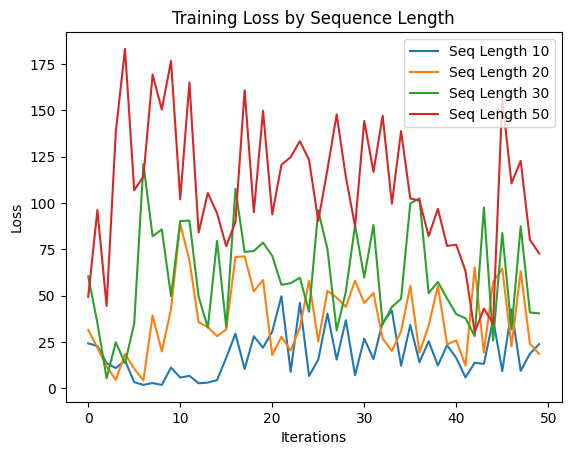

In [21]:
import matplotlib.pyplot as plt

# Plotting
for seq_length in sequence_lengths:
    plt.plot(performance_metrics[seq_length]['losses'], label=f'Seq Length {seq_length}')

plt.title('Training Loss by Sequence Length')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()